# 2023/2024 - Ma412 

# Lab 7: Clustering 

The objective of this notebook is to introduce and code the K-means clustering algorithm.

## <font color='black'>Set-Up</font>
First we will import the packages that we will need throughout the notebook.

In [268]:
import os
import numpy as np
import re

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

from IPython.display import HTML, display, clear_output

try:
    pyplot.rcParams["animation.html"] = "jshtml"
except ValueError:
    pyplot.rcParams["animation.html"] = "html5"

from scipy import optimize
from scipy.io import loadmat
import utils

%load_ext autoreload
%autoreload 2

# tells matplotlib to embed plots within the notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## K-means Clustering

---
Today you will implement the K-means clustering algorithm. Firstly, we will implement the algorithm for a 2D dataset.


### Implementation

K-means is an algorithm to automatically cluster data examples that are similar together. Notably, for a given training set $\{x^{(1)} , \cdots, x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), the goal is to define the clusters. The algorithm initializes randomly the centroids, and then it asigns the examples to the cluster corresponding to the closest centroids and then recomputes the centroids. 


The K-means algorithm is as follows:

```python
centroids = kMeansInitCentroids(X, K)
for i in range(iterations):
    # Cluster assignment step: Assign each data point to the
    # closest centroid. idx[i] corresponds to cˆ(i), the index
    # of the centroid assigned to example i
    idx = findClosestCentroids(X, centroids)
    # Move centroid step: Compute means based on centroid
    # assignments
    centroids = computeMeans(X, idx, K)
```

Note that the final solution depends on the initial setting of the centroids. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

#### Determine the closest centroids

Complete the code in the function `findClosestCentroids`. This function takes the data matrix `X` and the locations of all centroids inside `centroids` and outputs a vector `idx` that holds the index of the closest centroid to every training example.

In this case, you can implement this using a loop over every training example and every centroid.

In [269]:
#EDIT THIS CELL
def findClosestCentroids(X, centroids):
    # Set the number of clusters
    K = centroids.shape[0]

    # The centroids are in the following variable
    idx = np.zeros(X.shape[0], dtype=int)

    for k in range(K):
        min_c = 1000
        i = 0
        for centroid in centroids:
            if np.linalg.norm(centroid-X[k]) < min_c:
                index_k = i
                min_c = np.linalg.norm(centroid-X[k])
            i += 1
        idx[k] = index_k
    
    return idx

In [270]:
data = loadmat(os.path.join('data', 'ex7data2.mat'))
X = data['X']
K = 3   # 3 Centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
idx = findClosestCentroids(X, initial_centroids)
print('Closest centroids for the first 3 examples:')
print(idx[:3])
print('(the closest centroids should be 0, 2, 1 respectively)')

Closest centroids for the first 3 examples:
[0 2 1]
(the closest centroids should be 0, 2, 1 respectively)


Once you have completed the code in `findClosestCentroids`, the following cell will run your code and you should see the output `[0 2 1]` corresponding to the centroid assignments for the first 3 examples.

### Computing centroid means

Once the algorithm has performed assignments of every point to a centroid, the second part updates, for each centroid, the mean of the points that were assigned to it. 

Complete then the function `computeCentroids`. You can implement this function using a loop over the centroids.

In [271]:
#EDIT THIS CELL
def computeCentroids(X, idx, K):
    m, n = X.shape
    # The centroids are in the following variable
    centroids = np.zeros((K, n))

    for i in range(K):
        centroids[i] = np.mean(X[idx == i], axis=0)
    return centroids

Check your implementation by running the following cell.

In [272]:
centroids = computeCentroids(X, idx, K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)
print('\nThe centroids should be')
print('   [ 2.428301 3.157924 ]')
print('   [ 5.813503 2.633656 ]')
print('   [ 7.119387 3.616684 ]')

TypeError: hypot() takes from 2 to 3 positional arguments but 1 were given

### K-means example  

See in the following animation how the k-means algorithm proceeds.

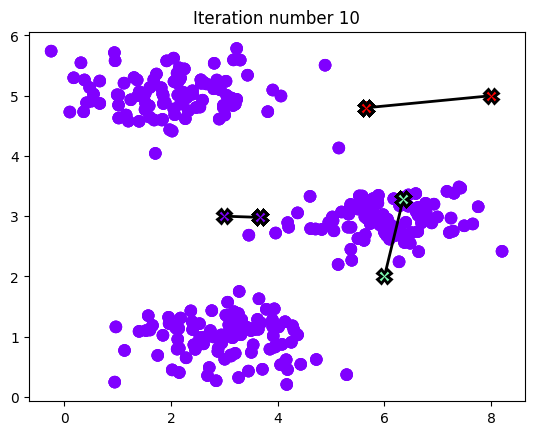

In [ ]:
# Load an example dataset
data = loadmat(os.path.join('data', 'ex7data2.mat'))

# Settings for running K-Means
K = 3
max_iters = 10

# For consistency, here we set centroids to specific values
# but in practice you want to generate them automatically, such as by
# settings them to be random examples (as can be seen in
# kMeansInitCentroids).
    
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
# Run K-Means algorithm. The 'true' at the end tells our function to plot
# the progress of K-Means
centroids, idx, anim = utils.runkMeans(X, initial_centroids,
                                       findClosestCentroids, computeCentroids, max_iters, True)
anim

### Random initialization 

A good strategy for initializing the centroids is to select random examples from the training set. Therefore, we can write,


```python
# Initialize the centroids to be random examples

# Randomly reorder the indices of examples
randidx = np.random.permutation(X.shape[0])
# Take the first K examples as centroids
centroids = X[randidx[:K], :]
```

The code above first *randomly* permutes the indices of the examples. Then, it selects the first $K$ examples based on the random permutation of the indices.

In [ ]:
#EDIT THIS CELL
def kMeansInitCentroids(X, K):

    m, n = X.shape
    
    # You should return this values correctly
    centroids = np.zeros((K, n))

    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K],:]
    
    return centroids

### Image compression with K-means

You will now apply K-means to image compression. 


In a 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (taking values from 0 to 255) that specify the red, green and blue values. 
Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors.

In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. You will process every pixel in the image as an example and use the K-means algorithm to find the 16 colors that correspond to the clusters' centroids in the 3-dimensional RGB space. Afterwards, you will use the 16 colors to replace the pixels in the original image.

The code in the following cell first loads the image, and then reshapes it to create an m x 3 matrix of pixel colors, and calls your K-means function on it.

After finding the top K = 16 colors to represent the image, you can now assign each pixel position to its closest centroid using the `findClosestCentroids` function. This allows you to represent the original image using the centroid assignments of each pixel. 

The figure below shows the reconstruction of the compressed image obtained. 

c:\Users\CE PC\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\CE PC\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


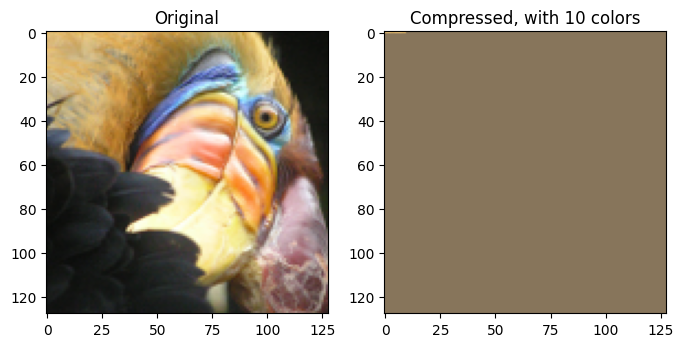

In [ ]:
# ======= Experiment with these parameters ================
# You should try different values for those parameters
K = 10
max_iters = 10

# Load an image of a bird
# Change the file name and path to experiment with your own images
A = mpl.image.imread(os.path.join('data', 'bird_small.png'))
# ==========================================================


# Divide by 255 so that all values are in the range 0 - 1
A /= 255

# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X that we will use K-Means on.
X = A.reshape(-1, 3)

# When using K-Means, it is important to randomly initialize centroids
# You should complete the code in kMeansInitCentroids above before proceeding
initial_centroids = kMeansInitCentroids(X, K)

# Run K-Means
centroids, idx = utils.runkMeans(X, initial_centroids,
                                 findClosestCentroids,
                                 computeCentroids,
                                 max_iters)

# We can now recover the image from the indices (idx) by mapping each pixel
# (specified by its index in idx) to the centroid value
# Reshape the recovered image into proper dimensions
X_recovered = centroids[idx, :].reshape(A.shape)

# Display the original image, rescale back by 255
fig, ax = pyplot.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(A*255)
ax[0].set_title('Original')
ax[0].grid(False)

# Display compressed image, rescale back by 255
ax[1].imshow(X_recovered*255)
ax[1].set_title('Compressed, with %d colors' % K)
ax[1].grid(False)

Comment the obtained result.

We see that the image have a lot less colors : the color of some pixels have been changed to correspond to the otained colors

In [ ]:
# My jupyter dont work on these images

In [ ]:
Conclude on the different obtained resuls.

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2682592476.py, line 1)

In [ ]:
#EDIT THIS CELL
# ============================================================
# Your answer here ...
# ============================================================